In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as tfhub

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# from bert import bert_tokenization
from pathlib import Path
import pickle
from pprint import pprint
from pathlib import Path
from sklearn import metrics as skmetrics
from collections import defaultdict
import tensorflow_addons as tfa

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

from tempfile import TemporaryDirectory
from tensorflow.keras import regularizers as reg


# Data

In [3]:
(ds_train_civil, train_info), (ds_val_civil, val_info), (ds_test_civil, test_info) = [
    tfds.load(
        "civil_comments", 
        split=split,     
        data_dir="data",
        with_info=True
    )
    for split in [
        "train", "validation", "test"
    ]
]

In [4]:
for toxicity in [
    (0,0.01),
    (0.01, 0.25),
    (0.25, 0.5),
    (0.5, 0.75),
    (0.75, 2)

]:
    print("toxicity", toxicity)
    t_min, t_max = toxicity
    for ds in [ds_train_civil, ds_val_civil]:
        n = 0
        for d in ds:
            x = d["text"]
            y = d["toxicity"]
            if t_min <= y.numpy() < t_max:
                print(x.numpy().decode())
                print(y.numpy())
                print()
                n+=1
            if n > 3:
                break
    print("-----")

toxicity (0, 0.01)
If at first you don't succeed...try again: http://www.seattletimes.com/business/boeing-aerospace/will-787-program-ever-show-an-overall-profit-analysts-grow-more-skeptical/
0.0

duties come before rights.
they have a duty to earn it if they can work.
0.0

Based upon the activities of the OHA I have always been of the opinion that being "cray cray" was a prerequisite for candidacy.  Apparently local voters prize the attribute.
0.0

It's a personal blog post written five years ago about a place you've never been.

What have you written that I can look through to see if you've written anything somewhat tone-deaf in the past five years?
0.0

Look at how much money the welfare and drug addict industries in Vancouver manage to pull in...
0.0

If  you don't care then good. Take your laws and shove it. Then there will be no problem with addicts. The laws are the problem.
0.0

I think that life in a lot of the villages is going to change under Trump.  There will be no subsidie

In [5]:
ds_train_civil_m = ds_train_civil.map(
    lambda d: (d["text"], int(d["toxicity"] > 0))
)

ds_val_civil_m = ds_val_civil.map(
    lambda d: (d["text"], int(d["toxicity"] > 0))
)

In [6]:
feature_desc = {
    "text": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64)
}

def parse(example):
    return tf.io.parse_single_example(example, feature_desc)

parse2 = lambda d: (d["text"], tf.cast(d["label"], tf.int32 ))

In [7]:
ds_train_supr = tf.data.TFRecordDataset(
    ["data/supremacists_train.tfrecord"]
).map(parse).map(parse2)

ds_val_supr = tf.data.TFRecordDataset(
    ["data/supremacists_train.tfrecord"]
).map(parse).map(parse2)

In [8]:
ds_train = ds_train_civil_m.concatenate(ds_train_supr)
ds_val = ds_val_civil_m#.concatenate(ds_val_supr)#.take(10000)

In [9]:
for toxicity in [0, 1]:
    print("toxicity", toxicity)
    
    for ds in [ds_train, ds_val]:
        n = 0
        for (x,y) in ds:
            if y.numpy() == toxicity:
                print(x.numpy().decode())
                print()
                n+=1
            if n > 5:
                break
        

toxicity 0
If at first you don't succeed...try again: http://www.seattletimes.com/business/boeing-aerospace/will-787-program-ever-show-an-overall-profit-analysts-grow-more-skeptical/

duties come before rights.
they have a duty to earn it if they can work.

Based upon the activities of the OHA I have always been of the opinion that being "cray cray" was a prerequisite for candidacy.  Apparently local voters prize the attribute.

It's a personal blog post written five years ago about a place you've never been.

What have you written that I can look through to see if you've written anything somewhat tone-deaf in the past five years?

Another biblical fundamentalist joins the circus.

Can't wait for the show to start!!

Don't forget Vancouver has banned gas for condo heating, so electricity must be the way they are going. Since the GVRD will continuously convert people to condos, their electric usage will climb rapidly.

Look at how much money the welfare and drug addict industries in Van

# Class imbalance

In [10]:
train_labels = np.array([y.numpy() for (x, y) in tqdm(ds_train)])
val_labels = np.array([y.numpy() for (x, y) in tqdm(ds_val)])

1812874it [05:02, 5992.45it/s]
97320it [00:15, 6346.02it/s]


In [11]:
# {
#     "train": train_labels.sum() / len(train_labels),
#     "val": val_labels.sum() / len(val_labels)
# }
# {'train': 0.29842780027734966, 'val': 0.2800702620584884}


In [12]:
# {
#     "train": len(train_labels),
#     "val": len(val_labels)
# }
# {'train': 1812874, 'val': 105320}


In [13]:
pos_percentage = 0.298

pos_weight = (1 - pos_percentage) / pos_percentage
pos_weight

2.3557046979865772

# Metrics

In [14]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

metrics

# Augmentation

In [15]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize(text, label):
    feature = {
        "text": _bytes_feature(text),
        "label": _int64_feature(label)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tf_serialize_example(text, label):
    tf_string = tf.py_function(
    serialize,
    (text, label),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ())

In [16]:
def augmenting_fn(augmenter):
    def fn(text_tensor):
        text = text_tensor.numpy().decode()
        try:
            return augmenter.augment(
                text
            )
        except:
            return text
    return lambda x, y: (tf.py_function(fn, [x], tf.string), y)


# Model

In [17]:
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        output_dim: int = 512
    ):
        super().__init__()
        self.key_dense = tf.keras.layers.Dense(output_dim)
        self.val_dense = tf.keras.layers.Dense(output_dim)
        self.qur_dense = tf.keras.layers.Dense(output_dim)
        self.final_dense = tf.keras.layers.Dense(output_dim)
    def attention(
        self,
        query,
        key,
        value
    ):
        score = tf.matmul(query, key, transpose_b=True)
        score = score / (tf.math.sqrt( tf.cast(tf.shape(key)[-1], tf.float32)))
        weights = tf.nn.softmax(score, axis=-1)
        output = weights @ value
        
        return output
    def call(self, inputs):
        query = self.qur_dense(inputs)
        key = self.key_dense(inputs)
        val = self.val_dense(inputs)
        
        attention = self.attention(
            query, key, val
        )
        
        return self.final_dense(attention)
    

In [18]:
module_handler = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = tfhub.KerasLayer(module_handler, trainable=True)

In [19]:
model = tf.keras.Sequential([
     tf.keras.layers.InputLayer(input_shape=([]), dtype=tf.string),
     use_layer,
     AttentionBlock(),
#      tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg.l2(1e-3), bias_regularizer=reg.l2(1e-4)),
#      tf.keras.layers.Dropout(0.2),
#      tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg.l2(1e-3), bias_regularizer=reg.l2(1e-4)),
#      tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=reg.l2(1e-3), bias_regularizer=reg.l2(1e-4))
])

model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.3),
      optimizer=tf.optimizers.Adam(learning_rate=4e-3), 
      metrics=metrics
     )

In [20]:
aug = naw.SynonymAug(
                aug_src='wordnet'
            )

def ds_train_iter():
    for (x, y) in ds_train:
#         x = aug.augment(x.numpy().decode())
        x= x.numpy().decode()
        y = int(y.numpy())
        yield (x,y)

In [21]:
ds_train_2 = tf.data.Dataset.from_generator(
    ds_train_iter, output_types=(tf.string, tf.int32))


In [22]:
for x,y in ds_train_2:
    print(x)
    print(y)
    break

tf.Tensor(b"btw, Globe, your new comment section is lame. \n\nI hit yes everytime because I believe EVERYONE has the right to say whatever they want! I'd rather hear the bad stuff than bury my head in the sand like our snowflakes.", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int32)


In [23]:

        
        
model.fit(
    ds_train.batch(196),
    epochs=5,
    class_weight={
        0: 1,
        1: pos_weight 
    },
    validation_data=ds_val.batch(196)
)

Epoch 1/5
9250/9250 [==============================] - 1714s 185ms/step - loss: 0.8714 - accuracy: 0.7488 - precision: 0.5641 - recall: 0.6970 - auc: 0.8091 - val_loss: 0.6025 - val_accuracy: 0.7732 - val_precision: 0.9189 - val_recall: 0.2500 - val_auc: 0.8276
Epoch 2/5
9250/9250 [==============================] - 1712s 185ms/step - loss: 0.7338 - accuracy: 0.8902 - precision: 0.7795 - recall: 0.8816 - auc: 0.9475 - val_loss: 0.6107 - val_accuracy: 0.7872 - val_precision: 0.7594 - val_recall: 0.4038 - val_auc: 0.7850
Epoch 3/5
9250/9250 [==============================] - 1711s 185ms/step - loss: 0.6577 - accuracy: 0.9557 - precision: 0.9059 - recall: 0.9504 - auc: 0.9810 - val_loss: 0.6406 - val_accuracy: 0.7768 - val_precision: 0.7290 - val_recall: 0.3825 - val_auc: 0.7685
Epoch 4/5
9250/9250 [==============================] - 1708s 185ms/step - loss: 0.6492 - accuracy: 0.9641 - precision: 0.9218 - recall: 0.9614 - auc: 0.9847 - val_loss: 0.6656 - val_accuracy: 0.7722 - val_precision

In [24]:
experiment_name = "use_attention_v2"


results_path = Path("results")
results_path.mkdir(exist_ok=True)


histories = dict()
for p in results_path.glob("*/history.pkl"):
    with p.open("rb") as f:
        histories[p.parent.name] = pickle.load(f)
        
assert experiment_name not in histories.keys(), f"{experiment_name} already loaded to history. Rerun this cell with other experiment_name or run the next cell."

(results_path / experiment_name).mkdir(exist_ok=True)
histories[experiment_name] = model.history.history

with (results_path / experiment_name / "history.pkl").open("wb") as f:
    pickle.dump(histories[experiment_name], f)
    
with (results_path / experiment_name / "model.sum").open("w") as f:
    model.summary(print_fn=lambda l: f.write(l + "\n"))

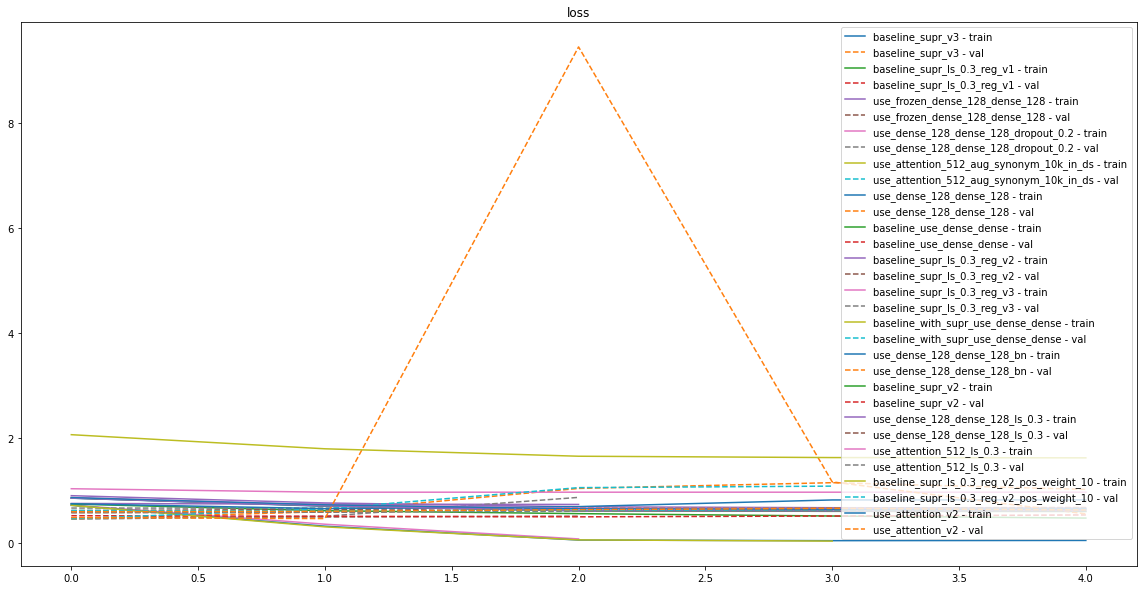

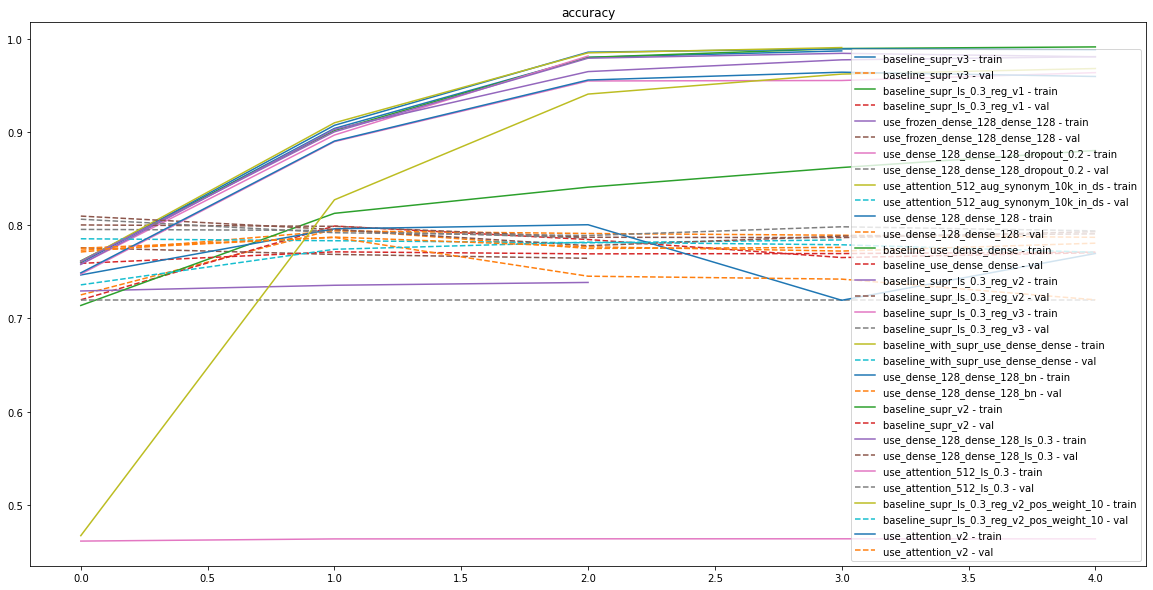

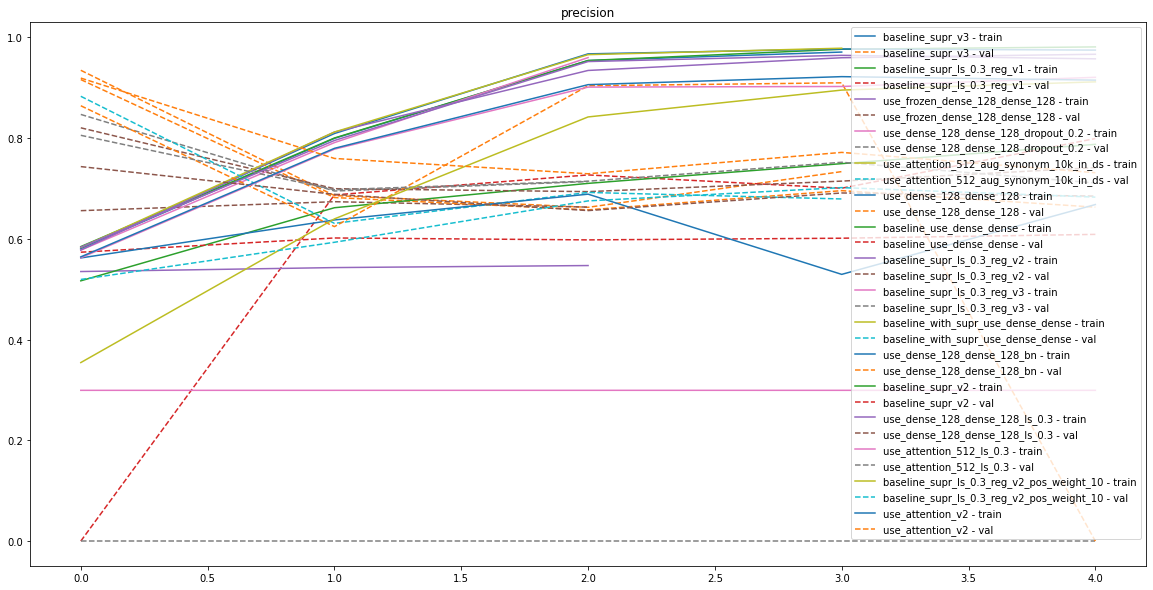

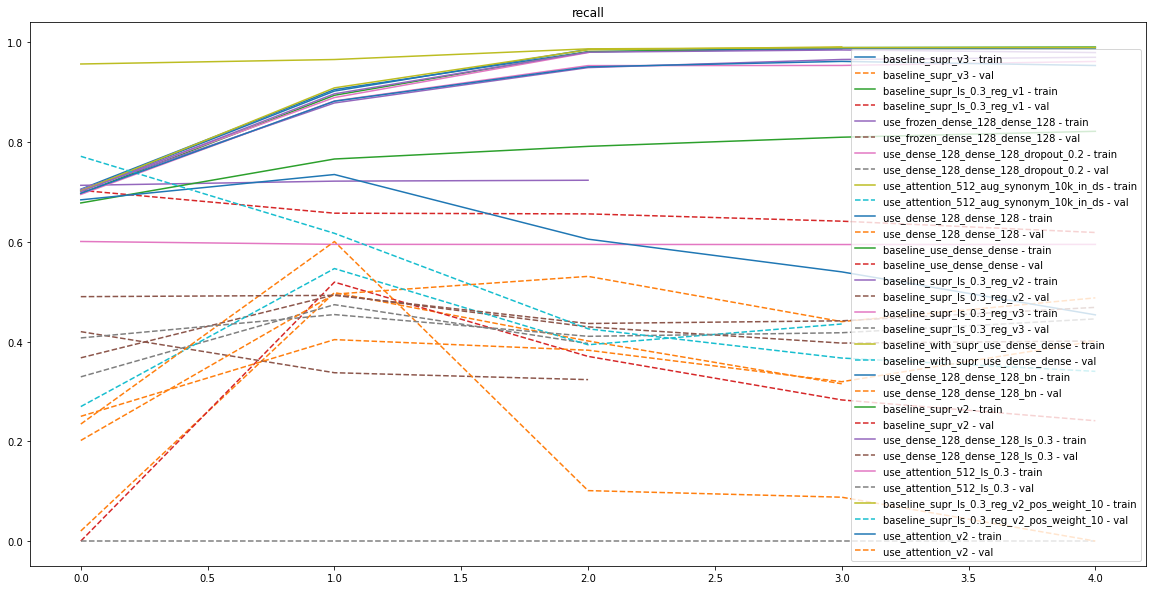

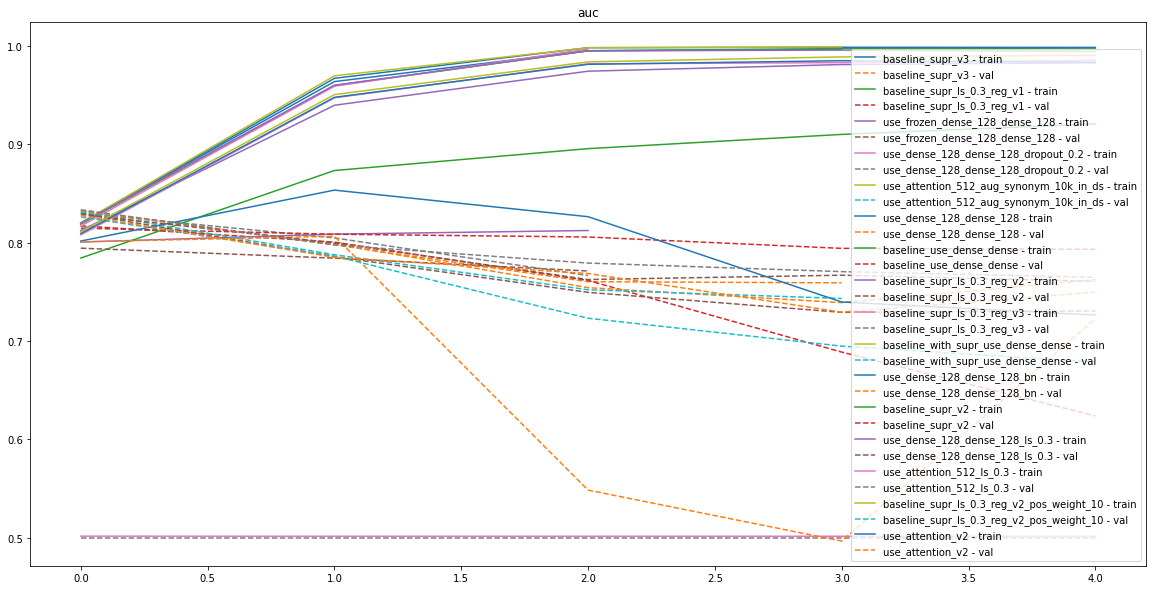

In [25]:
metrics_names = [
    n for n in list(histories.values())[0].keys() 
    if "val" not in n
    and n not in ["tp", "fp", "fn", "tn"]
]

model_metrics = defaultdict(dict) 

for n in metrics_names:

    plt.figure(figsize=(20, 10))

    plt.title(n)
    for exp_name, exp_history in histories.items():
        if "focal" in exp_name:
            continue
        train_history, val_history = [exp_history.get(f"{prefix}{n}", []) for prefix in ["", "val_"]]
        plt.plot(
            list(range(len(train_history))),
            train_history,
            label=f"{exp_name} - train"
        )
        plt.plot(
            list(range(len(val_history))),
            val_history,
            linestyle="--",
            label=f"{exp_name} - val"
        )
        
        model_metrics[exp_name][n] = train_history[-1]
        model_metrics[exp_name][f"{n}_val"] = val_history[-1]


        
        
    
    plt.legend()
    plt.show()

In [26]:
metrics_df = pd.DataFrame([
    {
        "model": model,
        **m
    }
    for model, m in model_metrics.items()
]).set_index("model")

def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

In [27]:
metrics_df.style.apply(highlight_max)

,loss,loss_val,accuracy,accuracy_val,precision,precision_val,recall,recall_val,auc,auc_val
model,,,,,,,,,,
baseline_supr_v3,0.612123,0.661066,0.986967,0.776111,0.970544,0.733302,0.986259,0.315252,0.996170,0.759047
baseline_supr_ls_0.3_reg_v1,0.607837,0.681889,0.991247,0.770480,0.980776,0.798900,0.990074,0.241211,0.997484,0.623821
use_frozen_dense_128_dense_128,0.740798,0.517086,0.738556,0.764461,0.546857,0.662847,0.723176,0.323592,0.812205,0.771092
use_dense_128_dense_128_dropout_0.2,0.084438,0.875472,0.981421,0.786327,0.959551,0.713527,0.979013,0.396108,0.996618,0.766434
use_attention_512_aug_synonym_10k_in_ds,0.614026,0.737970,0.986050,0.698823,0.969952,0.472551,0.983758,0.648710,0.996316,0.742174
use_dense_128_dense_128,0.055259,1.027256,0.988177,0.786973,0.974440,0.662718,0.986254,0.487473,0.998191,0.762314
baseline_use_dense_dense,0.481409,0.541151,0.880150,0.771085,0.787389,0.608715,0.821257,0.618465,0.920475,0.793137
baseline_supr_ls_0.3_reg_v2,0.673359,0.673547,0.980793,0.793040,0.966176,0.741228,0.969585,0.401058,0.982633,0.730478
baseline_supr_ls_0.3_reg_v3,0.974164,0.671707,0.463446,0.719930,0.299224,0.000000,0.594597,0.000000,0.501623,0.500000


In [28]:
metrics_df[[c for c in metrics_df.columns if "val" in c and "loss" not in c]].style.apply(highlight_max)

,accuracy_val,precision_val,recall_val,auc_val
model,,,,
baseline_supr_v3,0.776111,0.733302,0.315252,0.759047
baseline_supr_ls_0.3_reg_v1,0.770480,0.798900,0.241211,0.623821
use_frozen_dense_128_dense_128,0.764461,0.662847,0.323592,0.771092
use_dense_128_dense_128_dropout_0.2,0.786327,0.713527,0.396108,0.766434
use_attention_512_aug_synonym_10k_in_ds,0.698823,0.472551,0.648710,0.742174
use_dense_128_dense_128,0.786973,0.662718,0.487473,0.762314
baseline_use_dense_dense,0.771085,0.608715,0.618465,0.793137
baseline_supr_ls_0.3_reg_v2,0.793040,0.741228,0.401058,0.730478
baseline_supr_ls_0.3_reg_v3,0.719930,0.000000,0.000000,0.500000


In [29]:
metrics_df[metrics_df.precision_val > 0.4][metrics_df.recall_val > 0.4]

/media/data-disk-slow/anaconda3/envs/mp_personal/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,loss,loss_val,accuracy,accuracy_val,precision,precision_val,recall,recall_val,auc,auc_val
model,,,,,,,,,,
use_attention_512_aug_synonym_10k_in_ds,0.614026,0.737970,0.986050,0.698823,0.969952,0.472551,0.983758,0.648710,0.996316,0.742174
use_dense_128_dense_128,0.055259,1.027256,0.988177,0.786973,0.974440,0.662718,0.986254,0.487473,0.998191,0.762314
baseline_use_dense_dense,0.481409,0.541151,0.880150,0.771085,0.787389,0.608715,0.821257,0.618465,0.920475,0.793137
baseline_supr_ls_0.3_reg_v2,0.673359,0.673547,0.980793,0.793040,0.966176,0.741228,0.969585,0.401058,0.982633,0.730478
baseline_with_supr_use_dense_dense,0.042849,1.089626,0.990552,0.784182,0.978218,0.679012,0.990394,0.435095,0.998714,0.743175
use_dense_128_dense_128_ls_0.3,0.620120,0.638141,0.980658,0.790695,0.957128,0.684672,0.979039,0.468387,0.994100,0.760597
use_attention_512_ls_0.3,0.647083,0.631588,0.963649,0.793885,0.920461,0.710730,0.961256,0.445300,0.985057,0.764666
use_attention_v2,0.653214,0.637050,0.959528,0.780672,0.914826,0.731098,0.953121,0.401049,0.983116,0.749588


In [30]:
examples = [
        "I love you",
        "My lovely boy",
        "The government panders to gays",
        "Fuck you",
        "I'm a man and I think it's beautiful",
        "Samuel L Jackson is awesome",
        
]
pred = model.predict(
    tf.cast(
       examples 
    ,
        dtype=tf.string
    )
)
pred, pred > 0.5

(array([[0.15957929],
        [0.15957929],
        [0.54287887],
        [0.54287887],
        [0.15957929],
        [0.15957929]], dtype=float32),
 array([[False],
        [False],
        [ True],
        [ True],
        [False],
        [False]]))

# Report

In [31]:
def pred_report(model, ds):
    labels_gt = []
    labels_pred = []
    sentences = []

    for (x, y) in tqdm(ds.batch(1000)):
        labels_gt.extend(y.numpy().tolist())
        y_pred = model(x)
        labels_pred.extend(y_pred.numpy().tolist())
        sentences.extend([
            s.decode()
            for s in x.numpy()
        ])
    
    return sentences, labels_gt, labels_pred

# Save model

In [32]:
save_model_path = results_path / experiment_name / "saved" / "0"
tf.saved_model.save(
    model,
    str(save_model_path)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: results/use_attention_v2/saved/0/assets


INFO:tensorflow:Assets written to: results/use_attention_v2/saved/0/assets


In [33]:
loaded = tf.saved_model.load(str(save_model_path))
loaded.signatures.keys() # ["serving_default"]

KeysView(_SignatureMap({'serving_default': <tensorflow.python.saved_model.load._WrapperFunction object at 0x7f4977d09d90>}))

In [34]:
loaded(
    tf.cast(
       examples 
    ,
        dtype=tf.string
    )
)

<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.15957929],
       [0.15957929],
       [0.54287887],
       [0.54287887],
       [0.15957929],
       [0.15957929]], dtype=float32)>

# Ensembling

In [35]:
class Ensemble(tf.keras.Model):
    def __init__(self, sub_models, precisions: tf.Tensor = None, recalls: tf.Tensor = None):
        super().__init__()
        self.sub_models = sub_models
        
        if precisions is None:
            precisions = [1.] * len(sub_models)
        
        if recalls is None:
            recalls = [1.] * len(sub_models)
        
        self.precisions = tf.convert_to_tensor(precisions, dtype=tf.float32)
        self.recalls = tf.convert_to_tensor(recalls, dtype=tf.float32)
    
    def call(self, inputs):
        predictions = tf.stack([sm(inputs) for sm in self.sub_models])
        
        predictions = predictions - 0.5
        
        pos_predictions = tf.squeeze(predictions * tf.cast(predictions > 0, tf.float32))
        neg_predictions = tf.squeeze(predictions * tf.cast(predictions < 0, tf.float32))
        
        
        adjusted_predictions = tf.transpose(
            self.precisions* tf.transpose(pos_predictions)
        ) + tf.transpose(
            self.recalls * tf.transpose(neg_predictions)
        )  
        
        return tf.math.reduce_mean(
            adjusted_predictions, axis=0
        ) + 0.5
    


# Evaluate Ensembles

In [36]:
best_models = metrics_df[metrics_df.accuracy_val > 0.78][[c for c in metrics_df.columns if "val" in c and "loss" not in c]]
best_models

,accuracy_val,precision_val,recall_val,auc_val
model,,,,
use_dense_128_dense_128_dropout_0.2,0.786327,0.713527,0.396108,0.766434
use_dense_128_dense_128,0.786973,0.662718,0.487473,0.762314
baseline_supr_ls_0.3_reg_v2,0.793040,0.741228,0.401058,0.730478
baseline_with_supr_use_dense_dense,0.784182,0.679012,0.435095,0.743175
use_dense_128_dense_128_ls_0.3,0.790695,0.684672,0.468387,0.760597
use_attention_512_ls_0.3,0.793885,0.710730,0.445300,0.764666
use_attention_v2,0.780672,0.731098,0.401049,0.749588


In [37]:
best_models_names = []
precs = []
recs = []

for (n, row) in best_models.iterrows():
    best_models_names.append(n)
#     print(row.precision_val)
    precs.append(row.precision_val)
    recs.append(row.recall_val)
    
best_models_names

['use_dense_128_dense_128_dropout_0.2',
 'use_dense_128_dense_128',
 'baseline_supr_ls_0.3_reg_v2',
 'baseline_with_supr_use_dense_dense',
 'use_dense_128_dense_128_ls_0.3',
 'use_attention_512_ls_0.3',
 'use_attention_v2']

In [38]:
!nvidia-smi

Sun Jun  7 20:20:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 52%   61C    P8    13W / 250W |  10670MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   45C    P8    13W / 250W |    147MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [39]:
models = []
precisions = []
recalls = []

with tf.device("/cpu:0"):

    for model_name, p, r in tqdm(zip(best_models_names, precs, recs)):
        pth = results_path / model_name / "saved/0"
        if pth.exists():
            print(model_name)
            models.append(
                tf.saved_model.load(str(pth))
            )
            precisions.append(p)
            recalls.append(r)


0it [00:00, ?it/s]

baseline_supr_ls_0.3_reg_v2


3it [00:12,  4.25s/it]

baseline_with_supr_use_dense_dense


4it [00:25,  6.75s/it]

use_dense_128_dense_128_ls_0.3


5it [00:37,  8.34s/it]

use_attention_512_ls_0.3


6it [00:50,  9.90s/it]

use_attention_v2


7it [01:03,  9.07s/it]


In [40]:
ensemble = Ensemble(models, precisions, recalls)

In [41]:
snt, gt, pred = pred_report(
    ensemble,
    ds_val
)

98it [02:28,  1.52s/it]


In [42]:
{
    metric: metric(gt, pred)
    for metric 
    in metrics
}

{<tensorflow.python.keras.metrics.BinaryAccuracy at 0x7f4c2341e910>: <tf.Tensor: shape=(), dtype=float32, numpy=0.7806721>,
 <tensorflow.python.keras.metrics.Precision at 0x7f4bc0784450>: <tf.Tensor: shape=(), dtype=float32, numpy=0.718969>,
 <tensorflow.python.keras.metrics.Recall at 0x7f4bc0712e90>: <tf.Tensor: shape=(), dtype=float32, numpy=0.44675642>,
 <tensorflow.python.keras.metrics.AUC at 0x7f4bc0712f90>: <tf.Tensor: shape=(), dtype=float32, numpy=0.73023576>}